In [5]:
# Config paths (robusto para VS Code)
from pathlib import Path
import pandas as pd

# Si se ejecuta el notebook desde /notebooks, subimos un nivel al raíz del proyecto
PROJ = Path.cwd() if (Path.cwd().name != "notebooks") else Path.cwd().parent
DATA = PROJ / "data"

train_path = DATA / "train.csv"
assert train_path.exists(), f"No encuentro {train_path}. ¿Está en /data?"

test_path = DATA / "test.csv"
assert test_path.exists(), f"No encuentro {test_path}. ¿Está en /data?"

# Carga de datos
train = pd.read_csv(train_path)  # si pesa mucho, podés usar low_memory=True
print("Shape:", train.shape)
display(train.head())

# Carga de datos
test = pd.read_csv(test_path)
print("Shape:", test.shape)
display(test.head())

# Chequeos básicos
print("\nTipos:")
print(train.dtypes)
print("\nNulos (top 10):")
print(train.isna().sum().sort_values(ascending=False).head(10))


Shape: (79800, 21)


,id,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,41996,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,22,211533,False,0.305,0.8490,...,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth
1,76471,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",22,196000,False,0.287,0.1900,...,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera
2,54809,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,37,216506,False,0.583,0.5090,...,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm
3,16326,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",0,218346,False,0.163,0.0368,...,-23.149,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical
4,109799,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,27,173160,False,0.647,0.9210,...,-7.294,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno


Shape: (34200, 20)


,id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,113186,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,440247,False,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,42819,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,93933,False,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,59311,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",213578,False,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,91368,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,151387,False,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,61000,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,236293,False,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol



Tipos:
id                    int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

Nulos (top 10):
id              0
track_id        0
artists         0
album_name      0
track_name      0
popularity      0
duration_ms     0
explicit        0
danceability    0
energy          0
dtype: int64


In [6]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#GESTION DE VALORES NULOS O FALTANTES

# Separar la variable objetivo
target_col = "popularity"

X_train = train.drop(columns=[target_col])
y_train = train[target_col]

# Detectar columnas numéricas y categóricas SOLO en X_train
num_cols = X_train.select_dtypes(include=['number']).columns
cat_cols = X_train.select_dtypes(exclude=['number']).columns

# Definir el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", SimpleImputer(strategy="constant", fill_value="Unknown"), cat_cols),
    ]
)

# Ajustar solo con X_train (sin popularity)
preprocessor.fit(X_train)

# Transformar train y test
train_prepared = preprocessor.transform(X_train)
test_prepared  = preprocessor.transform(test)

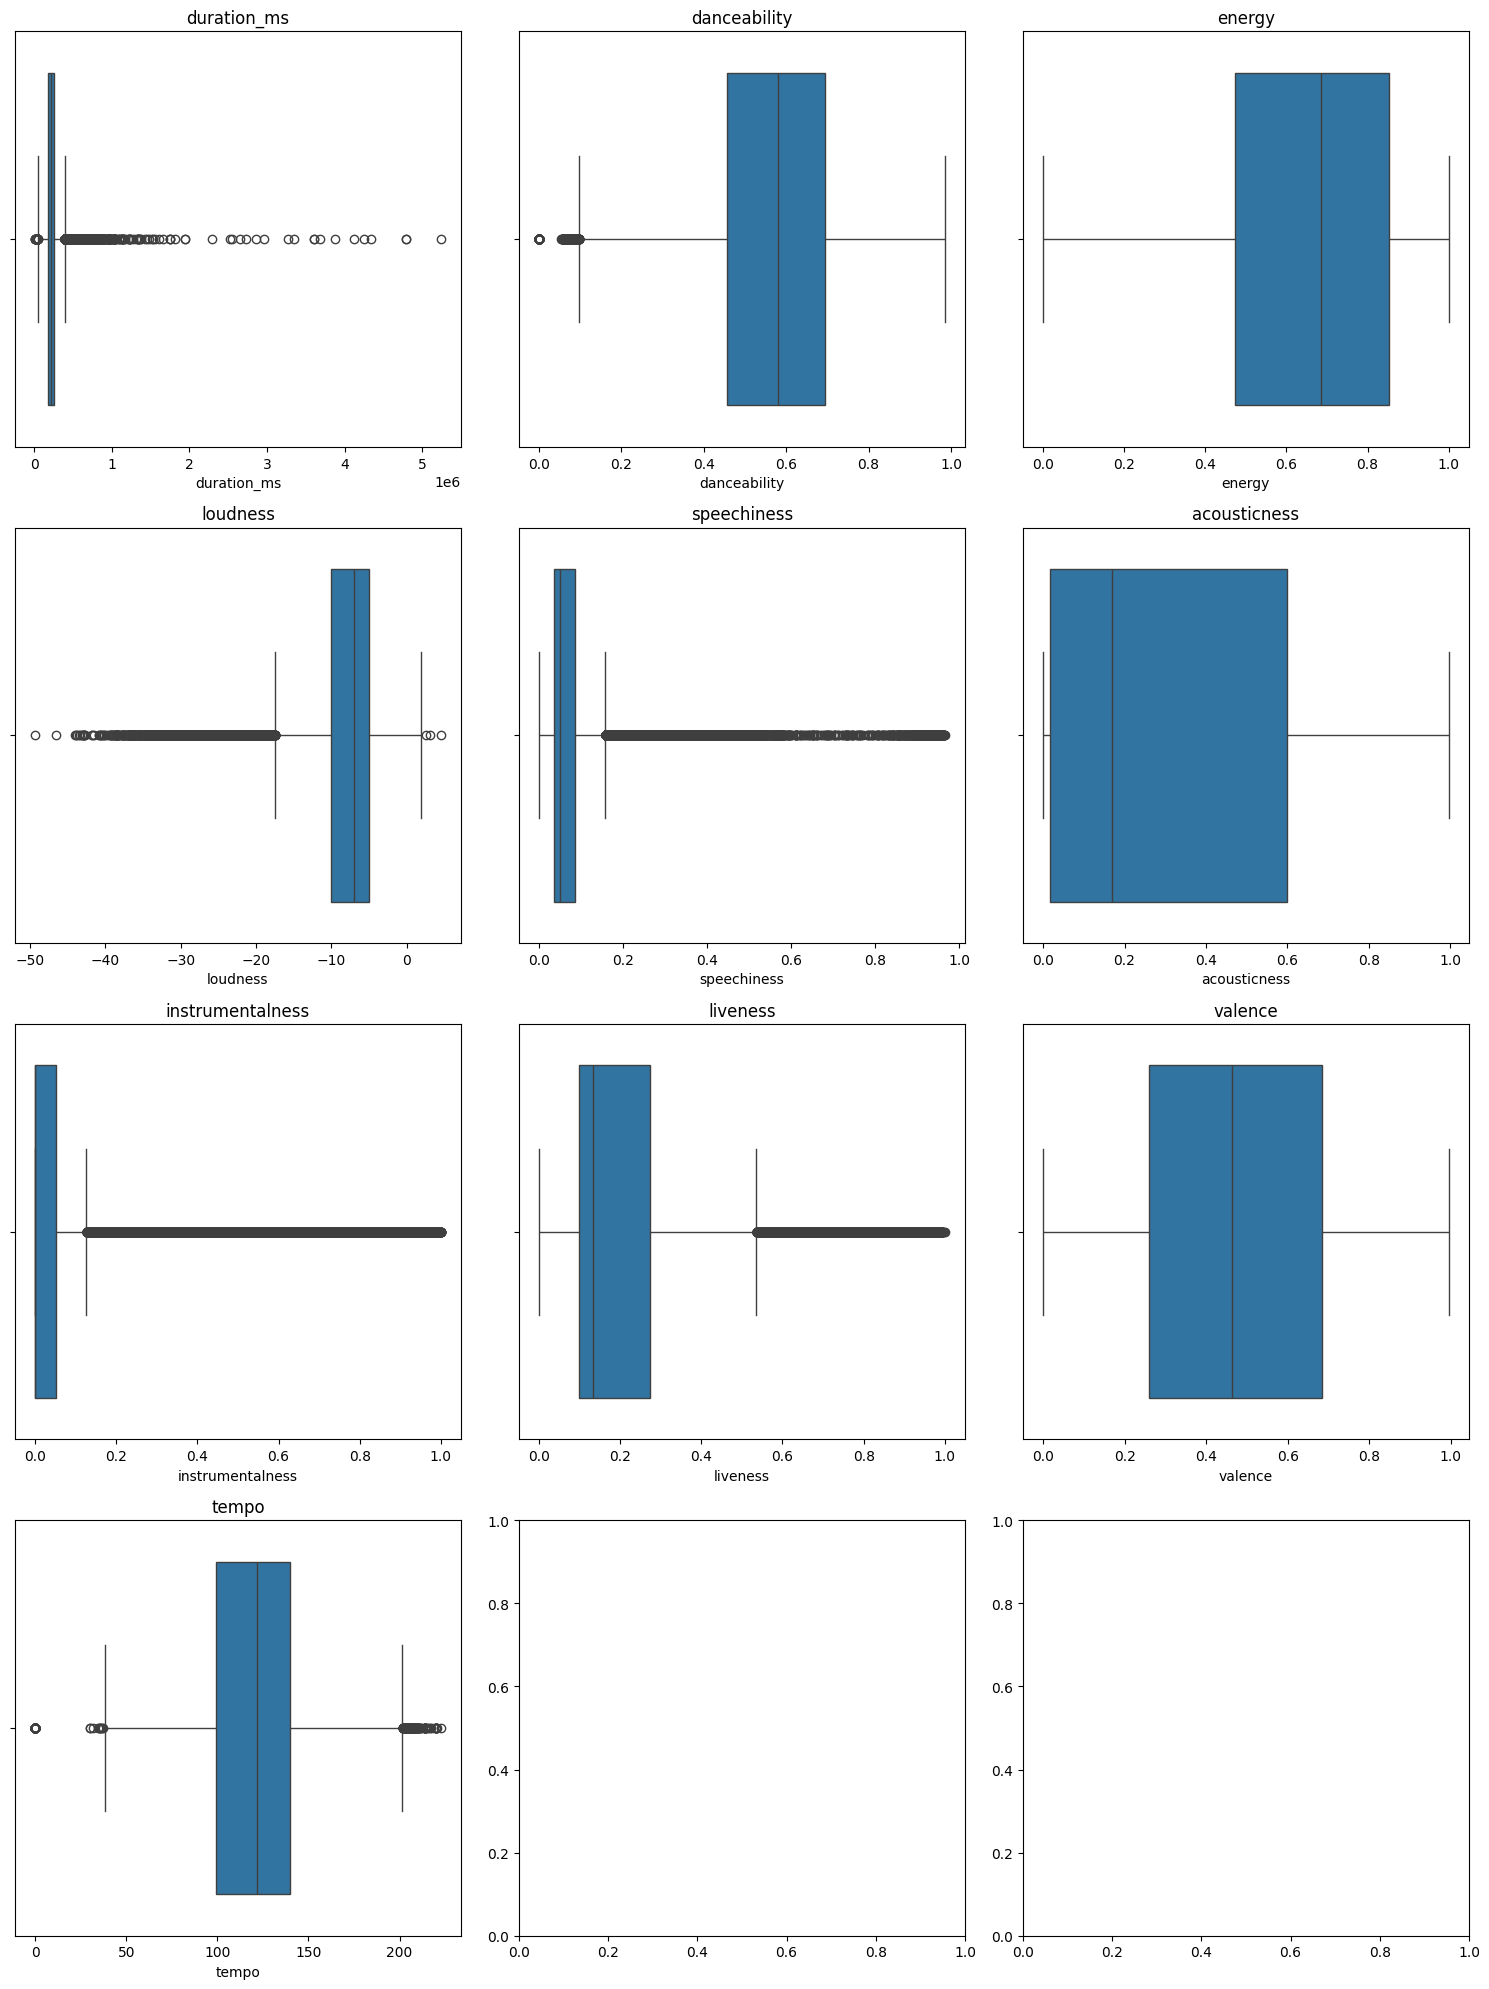

RESUMEN DE OUTLIERS POR COLUMNA:
duration_ms: 3990 outliers (5.00%)
danceability: 420 outliers (0.53%)
energy: 0 outliers (0.00%)
loudness: 4351 outliers (5.45%)
speechiness: 9277 outliers (11.63%)
acousticness: 0 outliers (0.00%)
instrumentalness: 17645 outliers (22.11%)
liveness: 6032 outliers (7.56%)
valence: 0 outliers (0.00%)
tempo: 424 outliers (0.53%)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NUMÉRICAS CONTINUAS: solo estas variables tienen sentido para outliers
num_continuous = [
    "duration_ms",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo"
]

# 1. VISUALIZACIÓN DE OUTLIERS
fig, axes = plt.subplots(len(num_continuous)//3 + 1, 3, figsize=(15, len(num_continuous)*2))
axes = axes.flatten()

for i, col in enumerate(num_continuous):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


# 2. MÉTODO IQR (Interquartile Range)
def detect_outliers_iqr(df, columns, factor=1.5):

    outliers_dict = {}
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        outliers_dict[col] = {
            'count': len(outliers),
            'percentage': len(outliers) / len(df) * 100,
            'lower': lower_bound,
            'upper': upper_bound
        }
    
    return outliers_dict


outliers_info = detect_outliers_iqr(train, num_continuous, factor=1.5)

# Mostrar resumen
print("RESUMEN DE OUTLIERS POR COLUMNA:")
for col, info in outliers_info.items():
    print(f"{col}: {info['count']} outliers ({info['percentage']:.2f}%)")


ANÁLISIS DE ASIMETRÍA (SKEWNESS):
------------------------------------------------------------
duration_ms         : skew =  10.75  --> MUY ASIMÉTRICA ⚠️
danceability        : skew =  -0.40  --> Simétrica ✓
energy              : skew =  -0.60  --> Asimetría moderada
loudness            : skew =  -2.01  --> MUY ASIMÉTRICA ⚠️
speechiness         : skew =   4.63  --> MUY ASIMÉTRICA ⚠️
acousticness        : skew =   0.73  --> Asimetría moderada
instrumentalness    : skew =   1.72  --> MUY ASIMÉTRICA ⚠️
liveness            : skew =   2.10  --> MUY ASIMÉTRICA ⚠️
valence             : skew =   0.11  --> Simétrica ✓
tempo               : skew =   0.24  --> Simétrica ✓

Columnas seleccionadas para log transform: ['duration_ms', 'speechiness', 'instrumentalness', 'liveness']

Columnas numéricas finales: ['id', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
Columnas categórica

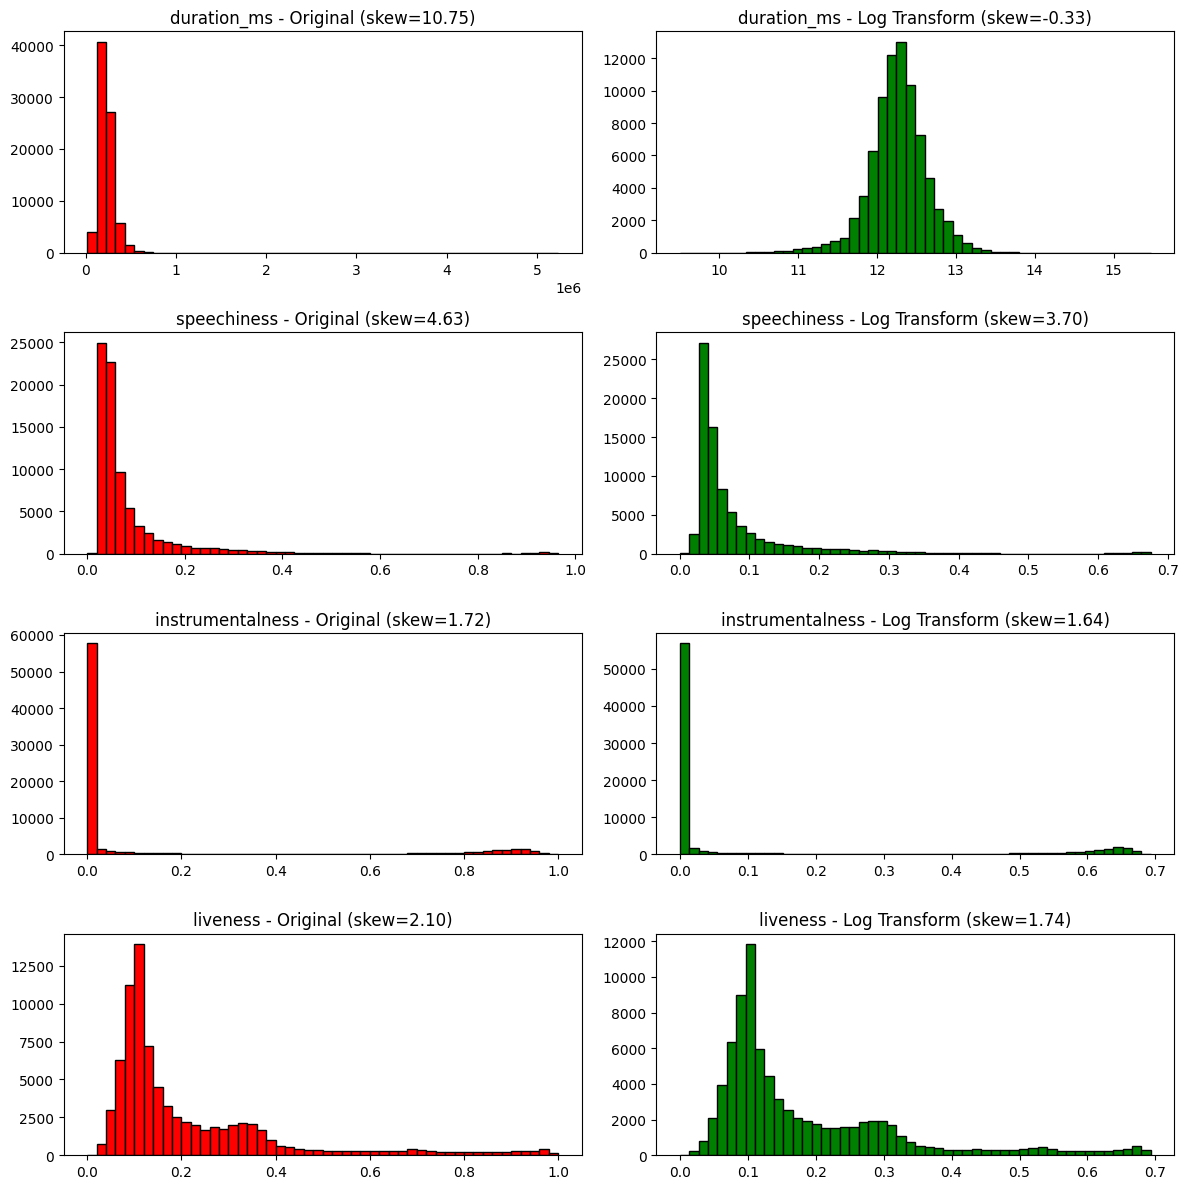

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor


# ============================================================
# 1. DEFINIR VARIABLES CONTINUAS (correctas para skew/outliers)
# ============================================================

num_continuous = [
    "duration_ms",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo"
]

# ============================================================
# 2. ANÁLISIS DE ASIMETRÍA (solo para decidir log-transform)
# ============================================================

print("ANÁLISIS DE ASIMETRÍA (SKEWNESS):")
print("-" * 60)

skewness_results = {}
for col in num_continuous:
    s = train[col].skew()
    skewness_results[col] = s
    msg = "MUY ASIMÉTRICA ⚠️" if abs(s) > 1 else ("Asimetría moderada" if abs(s) > 0.5 else "Simétrica ✓")
    print(f"{col:20s}: skew = {s:6.2f}  --> {msg}")

# Variables muy asimétricas y positivas → aplicar log1p
skewed_cols = [
    col for col in num_continuous
    if abs(skewness_results[col]) > 1 and (train[col] >= 0).all()
]

print("\nColumnas seleccionadas para log transform:", skewed_cols)


# ============================================================
# 3. TRANSFORMADOR LOGARÍTMICO (FUNCIONAL Y SIN ERRORES)
# ============================================================

class LogTransformer(FunctionTransformer):
    """
    Transformador logarítmico seguro para pipelines
    """
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        super().__init__(
            func=self._log_transform,
            inverse_func=self._inverse_log_transform,
            validate=False,
            check_inverse=False   # ← NECESARIO PARA NO FALLAR
        )

    def _log_transform(self, X):
        X = X.copy()
        for col in self.columns_to_transform:
            if col in X.columns:
                X[col] = np.log1p(X[col])
        return X

    def _inverse_log_transform(self, X):
        X = X.copy()
        for col in self.columns_to_transform:
            if col in X.columns:
                X[col] = np.expm1(X[col])
        return X


log_transformer = LogTransformer(columns_to_transform=skewed_cols)


# ============================================================
# 4. DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS (CORREGIDO)
# ============================================================

# Numéricas verdaderas
num_cols = train.select_dtypes(include=["number"]).columns.tolist()
num_cols.remove("popularity")  # remover target

# COLUMNAS CATEGÓRICAS DE BAJA CARDINALIDAD → SOLO ESTAS
cat_cols = ["key", "mode", "time_signature", "explicit", "track_genre"]

print(f"\nColumnas numéricas finales: {num_cols}")
print(f"Columnas categóricas finales (baja cardinalidad): {cat_cols}")


# ============================================================
# 5. PIPELINES NUMÉRICO Y CATEGÓRICO
# ============================================================

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])


# ============================================================
# 6. COLUMN TRANSFORMER FINAL (SIN EXPLOTAR LA RAM)
# ============================================================

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
], remainder="drop")


# ============================================================
# 7. PIPELINE COMPLETO CON MODELO
# ============================================================

pipeline = Pipeline([
    ("log_transform", log_transformer),
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    ))
])


# ============================================================
# 8. ENTRENAMIENTO (SIN DATA LEAKAGE)
# ============================================================

X_train = train.drop(columns=["popularity"])
y_train = train["popularity"]

print("\nEntrenando modelo...")
pipeline.fit(X_train, y_train)
print("✓ Entrenamiento completado correctamente")


# ============================================================
# 9. Cargar test y predecir
# ============================================================

test_path = DATA / "test.csv"
test = pd.read_csv(test_path)

y_pred = pipeline.predict(test)

print(f"\n✓ Predicciones generadas: {len(y_pred)}")
print(f"Rango de predicciones: {y_pred.min():.2f} – {y_pred.max():.2f}")



# ============================================================
# 10. VISUALIZAR EFECTO DE LA TRANSFORMACIÓN LOGARÍTMICA
# ============================================================

fig, axes = plt.subplots(len(skewed_cols), 2, figsize=(12, len(skewed_cols)*3))

for i, col in enumerate(skewed_cols):
    ax0 = axes[i, 0] if len(skewed_cols) > 1 else axes[0]
    ax1 = axes[i, 1] if len(skewed_cols) > 1 else axes[1]

    ax0.hist(train[col], bins=50, color="red", edgecolor="black")
    ax0.set_title(f"{col} - Original (skew={train[col].skew():.2f})")

    transformed = np.log1p(train[col])
    ax1.hist(transformed, bins=50, color="green", edgecolor="black")
    ax1.set_title(f"{col} - Log Transform (skew={transformed.skew():.2f})")

plt.tight_layout()
plt.show()


In [9]:
train.to_csv("../data/train_processed.csv", index=False)
test.to_csv("../data/test_processed.csv", index=False)